In [438]:
#for loading files
import os
import glob
import pandas as pd
import numpy as np

#for visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk', font_scale=0.7)

## Loading data

Data is loaded as pandas dataframes to make them easier to manipulate and transform. TOC data are provided in a folder with multiple csv-files, so this is consolidated by looping through the folder, importing the dataset as panda dataframes and concatenate with the previously imported dataframes. The remaining data is imported straightforwardly as pandas dataframes. 

In [439]:
# ----------- Loading data ----------
# Operational cost data
path_TOC = os.getcwd() + "/DTO/Total_Operating_Costs/Actual_Costs" #Find the csv files in the working directory, 
files_TOC = glob.glob(path_TOC + "/*.csv") #loop through all csv files in folder
df_TOC = pd.concat(map(lambda file: pd.read_csv(file, sep=";"), files_TOC)) #read as panda dataframes and concatenate.

# TOC Future data
path_future_TOC = os.getcwd() + "/DTO/Total_Operating_Costs/Future_Budget/DTO_TOC_FUT_2020_2H.csv"
df_future_TOC = pd.read_csv(path_future_TOC, sep=";")

# Employees data
path_employees = os.getcwd() + "/DTO/Employee_data/DTO_EMPLOYEES_REA_2018_C.csv"
df_employees = pd.read_csv(path_employees, sep=",")

# Account data
path_accounts = os.getcwd() + "/Master_Data/DIM_MASTER_ACCOUNTGROUPS.csv"
df_accounts = pd.read_csv(path_accounts, sep=";")

# Organisation data
path_organisation = os.getcwd() + "/Master_Data/DIM_MASTER_ORGANISATION.csv"
df_org = pd.read_csv(path_organisation, sep=";")

## Consolidating and Transforming Data

* Consolidating actual and budgeted values to expand dataset range to make more useful insights/patterns. We beleive that this data still holds useful information about expectation/assumptions and expanded data allows to analyze patterns. It also allows to analyse if the budgeted values are meaningful compaed to the actal values.
* Added 'Source' column to allow us to see if the data rows originates from 'actual' observed values, 'future'/forecasted values or imputed values. 
* Camelback renaming to allow readability and calling with df.ColumnName
* Changing variable types to allow for operations, ex: datetime and integers.
* Extracting useful information from columns, for example the two digits from AccountNumber and only the year from the Year column
* Checking for consistency in data set.

In [440]:
# ----------- Consolidation and standard data cleaning ----------
#renaming to make it easier to call
df_TOC = df_TOC.rename(index=str, columns={"Account number": "AccountNumber", "Value DKK": "ValueDKK", "Cost Center":"CostCenter"})
df_future_TOC = df_future_TOC.rename(index=str, columns={"Account number": "AccountNumber", "Value DKK": "ValueDKK", "Cost Center":"CostCenter"})
df_employees = df_employees.rename(index=str, columns={"Cost Center":"CostCenter"})
df_accounts = df_accounts.rename(index=str, columns={"Account 2-digits": "AccountCode", "Account Type":"AccountType", "Account Group":"AccountGroup"})
df_org = df_org.rename(index=str, columns={"Location Code": "LocationCode", "Department Number": "DepartmentNumber", "Cost Center":"CostCenter"})

#TOC: Joining actual and future TOC data, add column to indicate source
df_TOC['Source'] = "actual"
df_future_TOC['Source'] = "future"
df_TOC = pd.concat([df_TOC, df_future_TOC])

#Employee: melt/format table
employees_unp = df_employees.melt(id_vars=['CostCenter'], var_name='Date', value_name='noEmployees')

#changing type to allow mathematical operations
df_TOC["ValueDKK"]=df_TOC["ValueDKK"].str.replace(',','.')
df_TOC["ValueDKK"]= df_TOC["ValueDKK"].astype(float).astype(int) #loses some precision but allows easier operations

#create meaningful data partitions from cell values
df_TOC['AccountCode'] = np.int64(df_TOC.AccountNumber.str[5:7])
df_TOC['Year'] = np.int64(df_TOC.Year.str[3::])

#datetime
df_TOC['Date'] = "1-" + df_TOC.Month.astype(str) + "-" + df_TOC.Year.astype(str)
df_TOC['Date'] = pd.to_datetime(df_TOC['Date'], format='%d-%m-%Y')
employees_unp['Date'] = employees_unp.Date.astype(str).str.replace('/', '-')
employees_unp['Date'] = pd.to_datetime(employees_unp['Date'], format='%m-%d-%Y')

#removing redundant data
df_TOC = df_TOC.drop(['AccountNumber', 'Year', 'Month'], axis=1)

#remove duplicates in master data (organisation)
df_org = df_org.drop(df_org[df_org["CostCenter"].duplicated()].index)

#check if we have cost data of all cost centeres
a = df_TOC.CostCenter.unique().tolist()
b = df_org.CostCenter.unique().tolist()
all(item in a for item in b)


True

## Handling Missing Data

There is missing data in both TOC and employee data.
1. TOC
    - There is a contiguous time period from september to end of year 2019, where no observation is included in tha dataset. Therefore we assume the case that business activity continues in these months and the data is actually missing from the data sets.
    - The data is filled with a combination of Last Observation Carried Forward (LOCF) principle and mean. In other words, the average values over the three last months are carried forward to the first missing month. It is reasonable to assume that costs associated with different cost centers are not booked each month. For example, if a business orders goods to be manufactured every two months or electricity bills paid every quarter. 
    - We have implemented a moving average, meaning that September is filled with avg. over June, July and August, and October is filled with avg over July, August and September. The reason for this is to try to imitate a natural movement in the values, better for visualization and to carry forward trends that existed in the previous three months of actual observed data. 
    - The above means that the December values will be filled with averages based on only imputed data, which is important to be aware of if decisions are havily based on this information.   
    
2. Employee data
    - The employee data have NaN values where values are not initally filled in the imported csv. This is filled with zero-values to allow for mathematical operations and to distinguish between actually missing data and zeroes.
    - Similairly to the TOC-data there are missing values for Sept-Dec 2019. Months are added and filled with NaN values. 

In [441]:
#----------- TOC ------------
# TOC: fill data for missing time-period by moving 3 month avg by cost center and account code
missing_dates = pd.date_range(start = '2018-01-02', end = '2020-12-01', freq='MS').difference(df_TOC["Date"]) #find missing dates
for d in missing_dates:
    df = df_TOC.loc[(df_TOC['Date'] >= (d - pd.DateOffset(months=3))) & (df_TOC['Date'] < d)] #gets all rows of three months previous of selected date
    df = df.groupby(['Date', 'CostCenter', "AccountCode"]).sum().ValueDKK.astype(int).reset_index() #sum over cost centeres and account codes
    df = df.groupby(['CostCenter', 'AccountCode']).mean().ValueDKK.astype(int).reset_index() #get avg of the three months
    df['Source'], df['Date'] = 'imputed', d #add source and selected missing date
    df_TOC = pd.concat([df_TOC, df]).sort_values('Date') #concatenate for each loop to allow moving three month avg.

#----------- Employee ------------
#fill initial missing values with 0
employees_unp['noEmployees'] = employees_unp['noEmployees'].fillna(0) # fill with 0

#fill potential negative values to 0
employees_unp['noEmployees'] = employees_unp['noEmployees'].astype(int)
employees_unp.at[employees_unp[employees_unp['noEmployees']<0].index.values, 'noEmployees'] = 0

missing_dates1 = pd.date_range(start = '2018-01-02', end = '2020-06-01', freq='MS').difference(employees_unp["Date"]) #find missing dates
unique_cost_centers = pd.unique(employees_unp["CostCenter"]) #take unique values of costcenters

for i in missing_dates1:
    for j in unique_cost_centers:
        employees_unp = employees_unp.append({"CostCenter": j, "Date": i, "noEmployees": np.nan}, ignore_index=True) #add new raws with new dates for all cc

#employee_cost_centers = employees_unp.sort_values(by = ["CostCenter", "Date"]) #sort by cc and date
#employee_cost_centers.interpolate(method='linear', inplace=True) #fills NaN values linearly

## Task 1:
* Graphs are made in Tableau.
* Below is a quick graph of costs by year

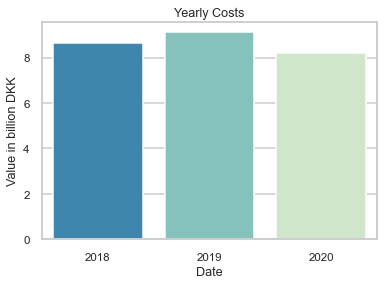

In [442]:
yearly_costs = df_TOC.groupby(df_TOC['Date'].dt.year).sum()

ax1 = sns.barplot(x = yearly_costs.index, y = yearly_costs.ValueDKK.div(1000000000), data = yearly_costs, 
palette = "GnBu_r")
ax1.set(ylabel='Value in billion DKK')
plt.title('Yearly Costs')

plt.show()

## Task 2:
* Number of employees are found by summing all numbers across different Cost centers for last observed month. 
* Graphs in Tableau
* Below is a quick overview of number of Employees per observed month

Number of employees in 6-1-2020: 8991


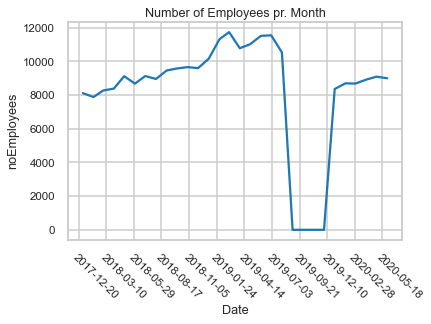

In [446]:
#Get number of employees from last observed date in original dataset. 
n_employees = df_employees.iloc[: , -1].sum().astype(int) #sum employees from the most recent month (lst column)
print("Number of employees in {0}: {1}".format(df_employees.keys()[-1].replace('/','-'), n_employees))

#-------------- Plot: number of employees by month -----------
df_total_employees = employees_unp.groupby(employees_unp.Date).sum().noEmployees

ax5 = sns.lineplot(data=df_total_employees)
ax5.xaxis.set_major_locator(plt.MaxNLocator(len(df_total_employees)/2))
plt.xticks(rotation = -45, ha="left", rotation_mode="anchor")
plt.title('Number of Employees pr. Month')

plt.show()

## Task 3: TODO - REFACTOR, CLEAN AND DISCUSS/EXPLAIN

In [444]:
### Task 3:

# ----------- Preparing data ----------
# remove spaces from each column if it is a string type
for col in df_accounts.columns:
    if df_accounts.dtypes[col] == object:
        for index in df_accounts.index:
            df_accounts.at[index, col] = df_accounts[col][index].strip()
            
# merging tables with employess and organisations
emp_org = pd.merge(employees_unp, df_org, on='CostCenter', how='inner') #tables with employess and organisations
print(emp_org.shape)
print(employees_unp.shape) #check that number of records are the same

# merging account data and costs data
TOC_acc = pd.merge(df_TOC, df_accounts, on = "AccountCode", how = "left") 

print(TOC_acc.shape)
print(df_TOC.shape) #check that number of records are the same. 
# Appeared that there are not because we have accCode 33 that is not in Master data. Assume that it is "other costs"
TOC_acc[TOC_acc.isnull().any(axis=1)]

TOC_acc_p = TOC_acc[TOC_acc["AccountGroup"] == "People"] #take only costs related to people

# creating new table that is group people costs data by CostCenter and Date to merge it with people data
grouped_TOC = TOC_acc_p.groupby(["CostCenter", "Date"]).sum() 

# merging all data together 
all_employee = pd.merge(grouped_TOC, emp_org, on = ["Date", "CostCenter"], how = "inner")

#create a column cost per employee for year data and fpr year + cost center data
# all_employee_date = all_employee.groupby("Date").sum()
# all_employee_date["CostEmployee"] = all_employee_date["ValueDKK"]/ all_employee_date["noEmployees"]

# all_employee_cc = all_employee.groupby(["Date", "CostCenter"]).sum()
# all_employee_cc["CostEmployee"] = all_employee_cc["ValueDKK"]/ all_employee_cc["noEmployees"]

# ----------- Displaying data ----------
display(all_employee)

(15090, 7)
(15090, 3)
(494274, 7)
(494274, 5)


,Date,CostCenter,ValueDKK,AccountCode,noEmployees,LocationCode,Location,Company,DepartmentNumber
0,2018-01-01,1,1918890,282,2.0,2000,Denmark,Company B,79_9
1,2018-02-01,1,1523598,217,2.0,2000,Denmark,Company B,79_9
2,2018-03-01,1,1518590,196,2.0,2000,Denmark,Company B,79_9
3,2018-04-01,1,1612954,152,2.0,2000,Denmark,Company B,79_9
4,2018-05-01,1,1576990,152,2.0,2000,Denmark,Company B,79_9
...,...,...,...,...,...,...,...,...,...
13141,2020-02-01,673,1793460,406,33.0,7000,Denmark,Company A,98_4
13142,2020-03-01,673,1793460,406,33.0,7000,Denmark,Company A,98_4
13143,2020-04-01,673,1808078,406,33.0,7000,Denmark,Company A,98_4
13144,2020-05-01,673,2007106,406,36.0,7000,Denmark,Company A,98_4


## Display and Export Dataframes

In [445]:
# ----------- Displaying data ----------
print('df_TOC')
display(df_TOC)

print('df_employees')
display(df_employees)

print('empl_cc') #TODO: change names to something readable
display(empl_cc)

print('df_accounts')
display(df_accounts)

print('df_org')
display(df_org)

#------------ Export data -----------
df_TOC.to_csv('./Transformed_data/TOC_transformed.csv')
empl_cc.to_csv('./Transformed_data/full_emp_data.csv') #TODO: change names to something readable
df_employees.to_csv('./Transformed_data/employees_transformed.csv')
df_accounts.to_csv('./Transformed_data/accounts_transformed.csv')
df_org.to_csv('./Transformed_data/org_transformed.csv')

df_TOC


,ValueDKK,CostCenter,Source,AccountCode,Date
32768,6070,20,actual,24,2018-01-01
10439,33353,394,actual,22,2018-01-01
58313,4895,663,actual,38,2018-01-01
58307,38014,663,actual,38,2018-01-01
10434,45464,394,actual,21,2018-01-01
...,...,...,...,...,...
4304,2356,358,future,22,2020-12-01
26774,92,224,future,24,2020-12-01
62871,21584,527,future,23,2020-12-01
26222,3237,2,future,24,2020-12-01


df_employees


,CostCenter,1/1/2018,2/1/2018,3/1/2018,4/1/2018,5/1/2018,6/1/2018,7/1/2018,8/1/2018,9/1/2018,...,5/1/2019,6/1/2019,7/1/2019,8/1/2019,1/1/2020,2/1/2020,3/1/2020,4/1/2020,5/1/2020,6/1/2020
0,360,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,239,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,8.0,8.0,8.0,6.0,6.0,6.0,6.0,6.0,6.0
4,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,9.0,9.0,9.0,19.0,19.0,19.0,19.0,19.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,124,192.0,212.0,195.0,24.0,24.0,24.0,27.0,27.0,185.0,...,19.0,18.0,186.0,19.0,139.0,139.0,139.0,138.0,138.0,138.0
499,119,236.0,222.0,216.0,238.0,239.0,245.0,247.0,252.0,252.0,...,249.0,249.0,32.0,247.0,195.0,195.0,195.0,197.0,197.0,197.0
500,110,247.0,24.0,243.0,253.0,253.0,253.0,254.0,254.0,254.0,...,246.0,231.0,224.0,217.0,2.0,2.0,2.0,23.0,24.0,24.0
501,97,254.0,25.0,248.0,253.0,254.0,254.0,255.0,255.0,255.0,...,278.0,239.0,251.0,237.0,198.0,196.0,196.0,199.0,2.0,2.0


empl_cc


,CostCenter,Date,noEmployees
191,1,2018-01-01,2.0
694,1,2018-02-01,2.0
1197,1,2018-03-01,2.0
1700,1,2018-04-01,2.0
2203,1,2018-05-01,2.0
...,...,...,...
10977,673,2020-02-01,33.0
11480,673,2020-03-01,33.0
11983,673,2020-04-01,33.0
12486,673,2020-05-01,36.0


df_accounts


,AccountCode,AccountType,AccountGroup
0,20,Salaries-1,People
1,21,Salaries-2,People
2,22,Pension & Bonus & Ad Hoc PayOuts,People
3,23,Raw Materials,Manufacturing
4,24,Price Variation,Manufacturing
5,27,Price Adjustments,Manufacturing
6,28,Transport-Road,Manufacturing
7,30,Shipment,Manufacturing
8,31,Safety,Manufacturing
9,32,Depreciation-Building,Other Costs


df_org


,LocationCode,Location,Company,DepartmentNumber,CostCenter
0,1000,India,Company B,70_9,98
1,1000,India,Company B,70_9,99
2,1000,India,Company B,70_9,101
3,1000,India,Company B,70_9,103
4,1000,India,Company B,70_9,122
...,...,...,...,...,...
672,7000,Denmark,Company E,28_1,542
673,7000,Denmark,Company E,28_1,553
674,7000,Denmark,Company E,28_1,555
675,7000,Denmark,Company F,11_5,525
